In [2]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy.random import randint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [3]:
# Import table with data
df_growth =  pd.read_csv(f'{homedir}/ctep_wt/data/raw/protein_quantification/Ctep_growth_Nov2022.csv') 
#Exclude values that don't belong to the experiment
df_growth = df_growth[(df_growth.Experiment =='Yes')]
#See data
df_growth.head()

,ID,Replicate,Timepoint,Time_h,Abs_669_chl,Bchl_c_ug_ml,ug_ml_protein,Calculated_cells_ml,Calculated_cells_ml_chl,Experiment,Sulfide_mM,Sulfate_mM,Unnamed: 12,Unnamed: 13,Note,Growth rates for all exp phase,csSOR for all exp
0,a,1.0,3.0,28.0,0.0124,0.144186,0.00000,6000000.0,8210000.0,Yes,1.625472,NaN,NaN,NaN,NaN,NaN,NaN
1,a,1.0,3.0,28.0,0.0124,0.144186,0.07308,5790000.0,8210000.0,Yes,1.238703,NaN,NaN,NaN,NaN,NaN,NaN
2,a,1.0,3.0,28.0,0.0124,0.144186,0.23410,5410000.0,8210000.0,Yes,NaN,NaN,a,1.0,0-70.5h,1.716809,36.429399
3,a,1.0,4.0,43.5,0.0198,0.230233,5.06470,42100000.0,12500000.0,Yes,1.077860,0.015787,aa,1.0,0-70.5h,1.640052,52.133678
4,a,1.0,4.0,43.5,0.0198,0.230233,5.22572,44900000.0,12500000.0,Yes,1.234568,NaN,aaa,1.0,0-70.5h,1.665484,33.133744


In [4]:
# Calculate the mean and standard deviation                           
df_group = df_growth.groupby(['ID', 'Replicate','Time_h']).agg(
                      {'ug_ml_protein':['mean','std'],
                    'Calculated_cells_ml':['mean','std'],
                      'Bchl_c_ug_ml':['mean'],
                       'Calculated_cells_ml':['mean','std'],
                      'Calculated_cells_ml_chl':['mean','std'],
                      'Sulfide_mM':['mean','std'],
                      'Sulfate_mM':['mean']})
#Change non existing values to 0
#df_group = df_group.fillna(0)
#Rename columns after agg
df_group.columns = ["_".join(x) for x in df_group.columns.ravel()]
#Drop first level of table after agg
df_group = df_group.reset_index()
df_group

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  del sys.path[0]


,ID,Replicate,Time_h,ug_ml_protein_mean,ug_ml_protein_std,Calculated_cells_ml_mean,Calculated_cells_ml_std,Bchl_c_ug_ml_mean,Calculated_cells_ml_chl_mean,Calculated_cells_ml_chl_std,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
0,a,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000e+00,0.000000,1000000.0,0.0,3.563604,0.353191,NaN
1,a,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.519538,NaN,NaN
2,a,1.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.711732,0.000000,NaN
3,a,1.0,28.0,0.102393,0.119771,5.733333e+06,2.990541e+05,0.144186,8210000.0,0.0,1.432088,0.273487,NaN
4,a,1.0,43.5,5.145210,0.113858,4.350000e+07,1.979899e+06,0.230233,12500000.0,0.0,1.156214,0.110810,0.015787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,full,2.0,144.5,2.648627,0.356048,1.223333e+07,2.797022e+06,2.636047,133000000.0,0.0,NaN,NaN,0.608692
136,full,2.0,210.5,3.047720,0.483774,1.565000e+07,4.454773e+06,2.854651,144000000.0,0.0,NaN,NaN,0.738930
137,full,2.0,309.0,2.192520,0.241887,9.105000e+06,1.407142e+06,2.596512,131000000.0,0.0,NaN,NaN,0.913272
138,full,2.0,387.5,2.278040,0.362831,9.655000e+06,2.184960e+06,2.206977,111000000.0,0.0,NaN,NaN,0.987168


In [25]:
df_full= df_group[(df_group.ID == 'full')]
df_full

,ID,Replicate,Time_h,ug_ml_protein_mean,ug_ml_protein_std,Calculated_cells_ml_mean,Calculated_cells_ml_std,Bchl_c_ug_ml_mean,Calculated_cells_ml_chl_mean,Calculated_cells_ml_chl_std,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean
118,full,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000e+00,0.000000,1000000.0,0.0,3.848566,0.058501,NaN
119,full,1.0,7.0,0.234100,0.161020,5.443333e+06,3.312602e+05,0.312791,16600000.0,0.0,3.080399,0.327908,NaN
120,full,1.0,18.0,0.663487,0.092965,4.903333e+06,4.041452e+04,0.381395,20100000.0,0.0,2.038063,0.000000,NaN
121,full,1.0,28.0,0.663487,0.092965,4.903333e+06,4.041452e+04,0.493023,25700000.0,0.0,1.720777,0.102094,0.000000
122,full,1.0,43.5,2.166340,NaN,7.445000e+06,2.043539e+06,0.606977,31300000.0,0.0,1.109537,0.042217,0.000000
123,full,1.0,70.5,3.615520,NaN,1.365000e+07,1.081873e+07,0.745349,38300000.0,0.0,0.285039,0.005030,0.000000
124,full,1.0,91.0,1.944880,0.166610,7.766667e+06,7.956339e+05,0.972093,49600000.0,0.0,0.059068,0.011904,0.000000
125,full,1.0,101.5,1.778270,0.288577,7.100000e+06,1.091192e+06,1.016279,51800000.0,0.0,0.000000,NaN,0.000000
126,full,1.0,121.5,1.223293,0.261268,5.416667e+06,5.424328e+05,1.100000,56000000.0,0.0,0.000000,NaN,0.009165
127,full,1.0,144.5,1.679400,NaN,6.600000e+06,NaN,0.915116,46800000.0,NaN,0.000000,NaN,0.019793


## Plots of cells and concentrations vs. time

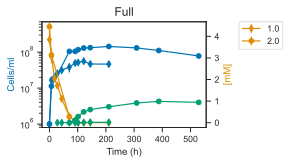

In [667]:
#Make a plot of cells and concentrations vs. time for full
#Filter by full
df_full= df_group[(df_group.ID == 'full')]
# Group by replicate
df_treatments = df_full.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=4)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean, yerr=data.Calculated_cells_ml_std, color=colors[0], marker=markers[i],
              label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('Full', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/full_cells.pdf', bbox_inches='tight')

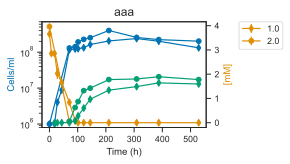

In [659]:
#Make a plot of cells and concentrations vs. time for aaa
#Filter by aaa
df_aaa= df_group[(df_group.ID == 'aaa')]
# Group by replicate
df_treatments = df_aaa.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean, yerr=data.Calculated_cells_ml_std, color=colors[0], marker=markers[i],
              label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('aaa', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/aaa_cells.pdf', bbox_inches='tight')

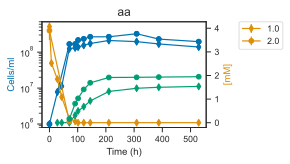

In [660]:
#Make a plot of cells and concentrations vs. time for aa
#Filter by aa
df_aa= df_group[(df_group.ID == 'aa')]
# Group by replicate
df_treatments = df_aa.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.scatter(data.Time_h, data.Calculated_cells_ml_chl_mean, color=colors[0], marker=markers[i],label = group)
    ax.plot(data.Time_h, data.Calculated_cells_ml_chl_mean, color=colors[0], marker=markers[i],label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('aa', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/aa_cells.pdf', bbox_inches='tight')

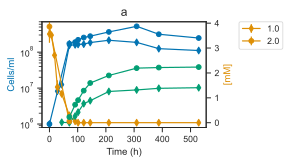

In [661]:
#Make a plot of cells and concentrations vs. time for a
#Filter by a
df_a= df_group[(df_group.ID == 'a')]
# Group by replicate
df_treatments = df_a.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean, yerr=data.Calculated_cells_ml_std, color=colors[0], marker=markers[i],
              label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('a', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/a_cells.pdf', bbox_inches='tight')

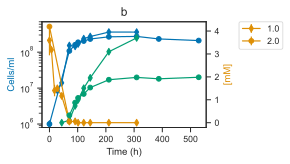

In [662]:
#Make a plot of cells and concentrations vs. time for b
#Filter by b
df_b= df_group[(df_group.ID == 'b')]
# Group by replicate
df_treatments = df_b.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean, yerr=data.Calculated_cells_ml_std, color=colors[0], marker=markers[i],
              label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('b', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/b_cells.pdf', bbox_inches='tight')

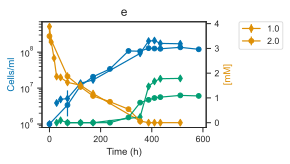

In [663]:
#Make a plot of cells and concentrations vs. time for e
#Filter by e
df_e= df_group[(df_group.ID == 'e')]
# Group by replicate
df_treatments = df_e.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.errorbar(data.Time_h, data.Calculated_cells_ml_chl_mean, yerr=data.Calculated_cells_ml_std, color=colors[0], marker=markers[i],
              label = group)
    ax2.errorbar(data.Time_h, data.Sulfide_mM_mean, yerr=data.Sulfide_mM_std, color=colors[1], marker=markers[i], label = group)
    ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Cells/ml', color=colors[0])
    ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('e', size=12)
    ax.set_yscale('log')
    ax.set_ylim([8e5, 7e8])

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)
#Save figure
fig.savefig(f'{homedir}/ctep_wt/figures/e_cells.pdf', bbox_inches='tight')

## Calculate growth rates and cell-specific sulfide oxidation rates (csSOR)

In [11]:
#Drop time duplicates
df_group_chl = df_group.drop_duplicates (['ID','Replicate','Time_h'])
#Remove time =7 and 18 h because they only have data for full
df_group_chl = df_group_chl.drop(df_group_chl[(df_group_chl['Time_h'] == 7) & (df_group_chl['ID'] != 'e')].index)
df_group_chl = df_group_chl.drop(df_group_chl[(df_group_chl['Time_h'] == 18) & (df_group_chl['ID'] != 'e')].index)
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_group_chl['ratio_cells_chl'] = df_group_chl['Calculated_cells_ml_chl_mean'].div(df_group_chl.groupby(['ID','Replicate'])['Calculated_cells_ml_chl_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each ID and Replicate
df_group_chl['diff_time_h'] = df_group_chl.groupby(['ID','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_group_chl['diff_cells_chl'] = df_group_chl.groupby(['ID','Replicate'])['Calculated_cells_ml_chl_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_group_chl['diff_sulfide_mM'] = df_group_chl.groupby(['ID','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_group_chl['growth_rate'] = np.log(df_group_chl['ratio_cells_chl'])*24/df_group_chl['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_group_chl['max_growth_rate']= df_group_chl.groupby(['ID','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_group_chl['csSOR'] = -(df_group_chl['max_growth_rate']*df_group_chl['diff_sulfide_mM']*10**9)/df_group_chl['diff_cells_chl']
#See dataframe
df_group_chl

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,Replicate,Time_h,ug_ml_protein_mean,ug_ml_protein_std,Calculated_cells_ml_mean,Calculated_cells_ml_std,Bchl_c_ug_ml_mean,Calculated_cells_ml_chl_mean,Calculated_cells_ml_chl_std,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,ratio_cells_chl,diff_time_h,diff_cells_chl,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
0,a,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000e+00,0.000000,1000000.0,0.0,3.563604,0.353191,NaN,0.000000,0.0,0.0,0.000000,-inf,2.237952,NaN
3,a,1.0,28.0,0.102393,0.119771,5.733333e+06,2.990541e+05,0.144186,8210000.0,0.0,1.432088,0.273487,NaN,8.210000,28.0,7210000.0,-2.131516,1.804588,2.237952,661.613318
4,a,1.0,43.5,5.145210,0.113858,4.350000e+07,1.979899e+06,0.230233,12500000.0,0.0,1.156214,0.110810,0.015787,1.522533,15.5,4290000.0,-0.275874,0.650904,2.237952,143.914268
5,a,1.0,70.5,2.111490,0.288577,8.696667e+06,1.478017e+06,3.079070,155000000.0,0.0,0.296826,0.008299,0.000000,12.400000,27.0,142500000.0,-0.859389,2.237952,2.237952,13.496636
6,a,1.0,91.0,3.944200,0.235622,2.535000e+07,3.040559e+06,3.175581,160000000.0,0.0,0.055770,0.002023,0.264955,1.032258,20.5,5000000.0,-0.241056,0.037169,2.237952,107.894364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,full,2.0,144.5,2.648627,0.356048,1.223333e+07,2.797022e+06,2.636047,133000000.0,0.0,NaN,NaN,0.608692,1.023077,23.0,3000000.0,0.000000,0.023807,1.584327,-0.000000
136,full,2.0,210.5,3.047720,0.483774,1.565000e+07,4.454773e+06,2.854651,144000000.0,0.0,NaN,NaN,0.738930,1.082707,66.0,11000000.0,0.000000,0.028896,1.584327,-0.000000
137,full,2.0,309.0,2.192520,0.241887,9.105000e+06,1.407142e+06,2.596512,131000000.0,0.0,NaN,NaN,0.913272,0.909722,98.5,-13000000.0,0.000000,-0.023054,1.584327,0.000000
138,full,2.0,387.5,2.278040,0.362831,9.655000e+06,2.184960e+06,2.206977,111000000.0,0.0,NaN,NaN,0.987168,0.847328,78.5,-20000000.0,0.000000,-0.050650,1.584327,0.000000


In [12]:
#Determine growth rates
#Create a new dataframe to get growth rates from the timepoints where growth was max
df_growth_rate = df_group_chl.sort_values('growth_rate', ascending=False).drop_duplicates(['ID','Replicate'])
#Calculate growth rates
#df_growth_rate['max_growth_rate'] = np.log(df_growth_rate['ratio_cells_chl'])*24/df_growth_rate['diff_time_h']
#Simplify dataframe
df_growth_rate = df_growth_rate.drop(df_growth_rate.columns[[3,4,5,6,7,8,9,10,11,12]], axis=1)
#Sort by ID and replicate
df_growth_rate = df_growth_rate.sort_values(['ID','Replicate'])
#Round the values of the dataframe to two decimal places
df_growth_rate = df_growth_rate.round(2)   
#See dataframe
df_growth_rate

,ID,Replicate,Time_h,ratio_cells_chl,diff_time_h,diff_cells_chl,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
5,a,1.0,70.5,12.40,27.0,142500000.0,-0.86,2.24,2.24,13.50
15,a,2.0,70.5,173.00,70.5,172000000.0,-3.81,1.75,1.75,38.89
28,aa,1.0,70.5,11.07,27.0,112800000.0,-0.91,2.14,2.14,17.29
38,aa,2.0,70.5,168.00,70.5,167000000.0,-3.85,1.74,1.74,40.25
52,aaa,1.0,70.5,13.20,27.0,107210000.0,-0.82,2.29,2.29,17.61
62,aaa,2.0,70.5,130.00,70.5,129000000.0,-3.91,1.66,1.66,50.28
76,b,1.0,70.5,10.93,27.0,139000000.0,-1.12,2.13,2.13,17.12
84,b,2.0,70.5,108.00,70.5,107000000.0,-4.15,1.59,1.59,61.76
102,e,1.0,387.5,2.19,33.0,110500000.0,-0.07,0.57,0.57,0.35
108,e,2.0,121.5,3.43,51.0,8220000.0,-0.43,0.58,0.58,30.19


In [13]:
#Determine growth rates
#Create a new dataframe to get growth rates from the timepoints where growth was max
df_growth_rate = df_group_chl[(df_group_chl.Time_h == 70.5)]
#Calculate growth rates
#df_growth_rate['max_growth_rate'] = np.log(df_growth_rate['ratio_cells_chl'])*24/df_growth_rate['diff_time_h']
#Simplify dataframe
df_growth_rate = df_growth_rate.drop(df_growth_rate.columns[[3,4,5,6,7,8,9,10,11,12]], axis=1)
#Sort by ID and replicate
df_growth_rate = df_growth_rate.sort_values(['ID','Replicate'])
#Round the values of the dataframe to two decimal places
df_growth_rate = df_growth_rate.round(2)   
#See dataframe
df_growth_rate

,ID,Replicate,Time_h,ratio_cells_chl,diff_time_h,diff_cells_chl,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
5,a,1.0,70.5,12.40,27.0,142500000.0,-0.86,2.24,2.24,13.50
15,a,2.0,70.5,173.00,70.5,172000000.0,-3.81,1.75,1.75,38.89
28,aa,1.0,70.5,11.07,27.0,112800000.0,-0.91,2.14,2.14,17.29
38,aa,2.0,70.5,168.00,70.5,167000000.0,-3.85,1.74,1.74,40.25
52,aaa,1.0,70.5,13.20,27.0,107210000.0,-0.82,2.29,2.29,17.61
62,aaa,2.0,70.5,130.00,70.5,129000000.0,-3.91,1.66,1.66,50.28
76,b,1.0,70.5,10.93,27.0,139000000.0,-1.12,2.13,2.13,17.12
84,b,2.0,70.5,108.00,70.5,107000000.0,-4.15,1.59,1.59,61.76
98,e,1.0,70.5,1.06,27.0,290000.0,-0.20,0.05,0.57,394.95
107,e,2.0,70.5,3.38,70.5,2380000.0,-1.62,0.41,0.58,395.32


In [9]:
# Calculate the mean and standard deviation  
df_growth_rate_group = df_growth_rate.groupby(['ID'])
df_stats = df_growth_rate_group.agg(
                    {'max_growth_rate':['mean','std'],
                     'csSOR':['mean','std']})
df_stats


max_growth_rate              csSOR            
                mean       std     mean         std
ID                                                 
a              1.995  0.346482   26.195   17.953441
aa             1.940  0.282843   28.770   16.235172
aaa            1.975  0.445477   33.945   23.101179
b              1.860  0.381838   39.440   31.565247
e              0.575  0.007071   15.270   21.100066
full           2.180  0.848528  151.680  124.507362

In [31]:
#Drop time duplicates
df_group_chl = df_group.drop_duplicates (['ID','Replicate','Time_h'])
#Remove time =7 and 18 h because they only have data for full
df_group_chl = df_group_chl.drop(df_group_chl[(df_group_chl['Time_h'] == 7) & (df_group_chl['ID'] != 'e')].index)
df_group_chl = df_group_chl.drop(df_group_chl[(df_group_chl['Time_h'] == 18) & (df_group_chl['ID'] != 'e')].index)
#Create a new dataframe to get growth rates from the timepoints where growth was max
df_group_chl = df_group_chl[(df_group_chl.Time_h == 0) | (df_group_chl.Time_h == 28)]
#Get ratios of cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_group_chl['ratio_cells_chl'] = df_group_chl['Calculated_cells_ml_chl_mean'].div(df_group_chl.groupby(['ID','Replicate'])['Calculated_cells_ml_chl_mean'].shift(1)).fillna(0) 
#Get differences between timepoints for each ID and Replicate
df_group_chl['diff_time_h'] = df_group_chl.groupby(['ID','Replicate'])['Time_h'].diff().fillna(0)
#Get differences between cells/ml calculated from chlorophyll between timepoints for each ID and Replicate
df_group_chl['diff_cells_chl'] = df_group_chl.groupby(['ID','Replicate'])['Calculated_cells_ml_chl_mean'].diff().fillna(0)
#Get differences between sulfide concentrations between timepoints for each ID and Replicate
df_group_chl['diff_sulfide_mM'] = df_group_chl.groupby(['ID','Replicate'])['Sulfide_mM_mean'].diff().fillna(0)
#Calculate growth rates in day^-1
df_group_chl['growth_rate'] = np.log(df_group_chl['ratio_cells_chl'])*24/df_group_chl['diff_time_h']
#Get maximum growth rates per ID and Replicate
df_group_chl['max_growth_rate']= df_group_chl.groupby(['ID','Replicate'])['growth_rate'].transform(max)
#Determine csSOR
df_group_chl['csSOR'] = -(df_group_chl['max_growth_rate']*df_group_chl['diff_sulfide_mM']*10**9)/df_group_chl['diff_cells_chl']
#See dataframe
df_group_chl

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,Replicate,Time_h,ug_ml_protein_mean,ug_ml_protein_std,Calculated_cells_ml_mean,Calculated_cells_ml_std,Bchl_c_ug_ml_mean,Calculated_cells_ml_chl_mean,Calculated_cells_ml_chl_std,Sulfide_mM_mean,Sulfide_mM_std,Sulfate_mM_mean,ratio_cells_chl,diff_time_h,diff_cells_chl,diff_sulfide_mM,growth_rate,max_growth_rate,csSOR
0,a,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.563604,0.353191,NaN,0.00,0.0,0.0,0.000000,-inf,1.804588,NaN
3,a,1.0,28.0,0.102393,0.119771,5.733333e+06,299054.064231,0.144186,8210000.0,0.0,1.432088,0.273487,NaN,8.21,28.0,7210000.0,-2.131516,1.804588,1.804588,533.496418
14,a,2.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.863279,0.246720,NaN,0.00,0.0,0.0,0.000000,-inf,-inf,NaN
24,aa,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,4.071439,0.110166,NaN,0.00,0.0,0.0,0.000000,-inf,1.760677,NaN
26,aa,1.0,28.0,0.609813,0.245962,4.996667e+06,117189.305542,0.136047,7800000.0,0.0,1.846042,0.047421,0.0,7.80,28.0,6800000.0,-2.225396,1.760677,1.760677,576.206628
37,aa,2.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.901079,0.396258,NaN,0.00,0.0,0.0,0.000000,-inf,-inf,NaN
47,aaa,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.657925,0.121203,NaN,0.00,0.0,0.0,0.000000,-inf,1.192527,NaN
50,aaa,1.0,28.0,0.000000,0.000000,6.000000e+06,0.000000,0.060465,4020000.0,0.0,2.031047,0.233523,0.0,4.02,28.0,3020000.0,-1.626878,1.192527,1.192527,642.416136
61,aaa,2.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.963179,0.134897,NaN,0.00,0.0,0.0,0.000000,-inf,-inf,NaN
71,b,1.0,0.0,0.000000,0.000000,6.000000e+06,0.000000,0.000000,1000000.0,0.0,3.595177,0.653701,NaN,0.00,0.0,0.0,0.000000,-inf,1.846359,NaN


## Plots of protein and Chl concentrations vs. time

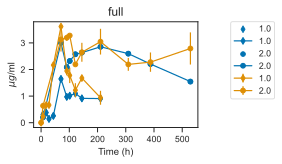

In [131]:
#Make a plot of cells and concentrations vs. time for full
#Filter by full
df_full= df_
[(df_group.ID == 'full')]
# Group by replicate
df_treatments = df_full.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.scatter(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.plot(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.errorbar(data.Time_h, data.ug_ml_protein_mean, yerr=data.ug_ml_protein_std, color=colors[1], marker=markers[i], label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('$\mu g$/ml')
    ax.set_title('full', size=12)

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)

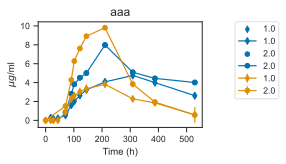

In [132]:
#Make a plot of cells and concentrations vs. time for aaa
#Filter by aaa
df_aaa= df_group[(df_group.ID == 'aaa')]
# Group by replicate
df_treatments = df_aaa.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.scatter(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.plot(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.errorbar(data.Time_h, data.ug_ml_protein_mean, yerr=data.ug_ml_protein_std, color=colors[1], marker=markers[i], label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('$\mu g$/ml')
    ax.set_title('aaa', size=12)

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)

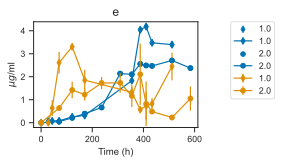

In [149]:
#Make a plot of cells and concentrations vs. time for e
#Filter by e
df_e= df_group[(df_group.ID == 'e')]
# Group by replicate
df_treatments = df_e.groupby(['Replicate'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=3)
# Define markers
markers = ['d', 'o']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_treatments):
    #print(group, data)
    ax.scatter(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.plot(data.Time_h, data.Bchl_c_ug_ml_mean, color=colors[0], marker=markers[i],
              label = group)
    ax.errorbar(data.Time_h, data.ug_ml_protein_mean, yerr=data.ug_ml_protein_std, color=colors[1], marker=markers[i], label = group)
    #ax2.errorbar(data.Time_h, data.Sulfate_mM_mean, color=colors[2], marker=markers[i])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('$\mu g$/ml')
    #ax2.set_ylabel('[mM]', color=colors[1])
    ax.set_title('e', size=12)

#Show legend
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)

In [37]:
#Filter by blank only
df_blank = df_bradford[(df_bradford.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank = df_blank['absorbance'].mean()
#Subtract average of the blank absorbance from all the absorbances
df_bradford['abs_corr'] = df_bradford['absorbance'] - avg_blank

#Make standard curve
#Filter by standard only
df_standard = df_bradford[(df_bradford.type == 'standard')]
df_standard.tail()
# Calculate linear regression
z = np.polyfit(df_standard.abs_corr, df_standard.hyp_conc, 1)
p = np.poly1d(z)
#Insert into a new column in the dataframe
df_standard.insert(4,'reg',p(df_standard['abs_corr']))
df_standard.head()

,cell,absorbance,type,hyp_conc,reg,treatment,replicate,time_h
0,A1,0.023333,standard,20.0,19.992566,NaN,NaN,NaN
1,A2,0.022333,standard,20.0,19.247202,NaN,NaN,NaN
2,A3,0.023333,standard,20.0,19.992566,NaN,NaN,NaN
3,A4,0.009333,standard,10.0,9.557477,NaN,NaN,NaN
4,A5,0.008333,standard,10.0,8.812114,NaN,NaN,NaN


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


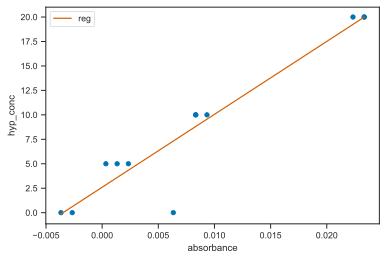

In [38]:
#Plot the regression line for the standard
ax = df_standard.plot.scatter(x = 'abs_corr',y='hyp_conc')
df_standard.plot(x = 'abs_corr',y='reg',color='r',ax=ax)

In [40]:
# Calculate the concentration of each sample

df_bradford['concentration'] = df_bradford['abs_corr']*z[0] + z[1]
# Show dataframe
df_bradford

,cell,absorbance,type,hyp_conc,treatment,replicate,time_h,concentration
0,A1,0.023333,standard,20.0,NaN,NaN,NaN,19.992566
1,A2,0.022333,standard,20.0,NaN,NaN,NaN,19.247202
2,A3,0.023333,standard,20.0,NaN,NaN,NaN,19.992566
3,A4,0.009333,standard,10.0,NaN,NaN,NaN,9.557477
4,A5,0.008333,standard,10.0,NaN,NaN,NaN,8.812114
...,...,...,...,...,...,...,...,...
91,H8,0.020333,sample,NaN,g,2.0,10.0,17.756475
92,H9,0.021333,sample,NaN,g,3.0,10.0,18.501839
93,H10,-0.070667,sample,NaN,g,1.0,20.0,-50.071602
94,H11,-0.069667,sample,NaN,g,2.0,20.0,-49.326238


In [51]:
# Filter by sample only
df_samples = df_bradford[(df_bradford.type == 'sample')]
df_samples.head()

,cell,absorbance,type,hyp_conc,treatment,replicate,time_h,concentration
12,B1,NaN,sample,NaN,NaN,NaN,NaN,NaN
13,B2,NaN,sample,NaN,NaN,NaN,NaN,NaN
14,B3,NaN,sample,NaN,NaN,NaN,NaN,NaN
15,B4,0.002333,sample,NaN,a,1.0,0.0,4.339933
16,B5,0.003333,sample,NaN,a,2.0,0.0,5.085296


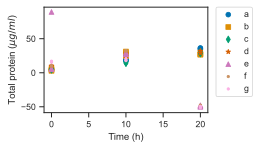

In [72]:
#Make a plot of concentration vs. time
# Group by treatment
df_group = df_samples.groupby(['treatment'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd','*','^','.','.']

# Define fig and axes
#fig, ax = plt.subplots(1,7, figsize=(9,6))
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    ax.scatter(data.time_h, data.concentration, color=colors[i], marker=markers[i],
              label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Total protein ($\mu g/ml$)')
#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)